In [1]:
# Basic tools
import os
import sys
import re
from time import sleep

# Data tools
import numpy as np
import pandas as pd
import scipy.spatial.distance as sdist
from scipy.stats import norm

# Scraping tools
import requests
from bs4 import BeautifulSoup

# Viz tools
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# NLP tools
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import Word2Vec, KeyedVectors
from gensim.corpora.wikicorpus import WikiCorpus
import spacy
snlp = spacy.load('en_core_web_sm')

# Local
## Allow local relative imports
module_path = os.path.abspath('..')
include_path = os.path.join(module_path, 'include')
data_path = os.path.join(module_path, 'data')
if include_path not in sys.path:
    sys.path.append(include_path)
from my_nlp import Tokenizer

In [ ]:
tok = Tokenizer()
sess = requests.Session()
wapi_url = "https://en.wikipedia.org/w/api.php"

In [76]:
bilinks_df = pd.read_csv(data_path + '/clickstream-enwiki-2018-08-bilinks.tsv', sep = '\t')

In [217]:
n_bilinks = 100

count_df_cols = ['origin_p_count', 'origin_newline_count', 'origin_sent_count', 'n_links_forward',
                 'target_p_count', 'target_newline_count', 'target_sent_count', 'n_links_backward']

for count_df_col in count_df_cols:
    bilinks_df[count_df_col] = 0

pos_df_cols = ['origin_p_pos', 'origin_newline_pos', 'origin_sent_pos', 'origin_sent',
               'target_p_pos', 'target_newline_pos', 'target_sent_pos', 'target_sent', 'match']

if os.path.exists(data_path + '/clickstream-enwiki-2018-08-sentences.tsv'):
    sent_df = pd.read_csv(data_path + '/clickstream-enwiki-2018-08-sentences.tsv', sep = '\t')
    start_bilink_ind = len(sent_df.groupby(by = ['origin_title', 'target_title']))
    sent_ind = sent_df.shape[0]
else:
    sent_df = pd.DataFrame(columns = bilinks_df.columns)

    for pos_df_col in pos_df_cols:
        sent_df[pos_df_col] = 0

    sent_df.to_csv(data_path + '/clickstream-enwiki-2018-08-sentences.tsv', sep = '\t', index = False)
    start_bilink_ind = 0
    sent_ind = 0

for bilink_ind in range(start_bilink_ind, start_bilink_ind + n_bilinks):
    sent_df = pd.DataFrame(columns = bilinks_df.columns)

    for pos_df_col in pos_df_cols:
        sent_df[pos_df_col] = 0

    origin_title, target_title = bilinks_df[['origin_title', 'target_title']].iloc[bilink_ind].tolist()

    origin_wapi_params = {
        'action': "parse",
        'maxlag': 5,
        'page': origin_title,
        'prop': "text",
        'contentformat': "text/plain",
        'format': "json"
    }

    while True:
        try:
            origin_data = sess.get(url = wapi_url, params = origin_wapi_params).json()
            origin_title_norm = origin_data['parse']['title']
            origin_text = origin_data['parse']['text']['*']
        except KeyError:
            sleep(1)
        else:
            break
    if isinstance(origin_text, bytes):
        origin_text = origin_text.decode()
    origin_soup = BeautifulSoup(origin_text, 'html5lib')

    target_wapi_params = {
        'action': "parse",
        'maxlag': 5,
        'page': target_title,
        'prop': "text",
        'format': "json"
    }

    while True:
        try:
            target_data = sess.get(url = wapi_url, params = target_wapi_params).json()
            target_title_norm = target_data['parse']['title']
            target_text = target_data['parse']['text']['*']
        except KeyError:
            sleep(1)
        else:
            break
    if isinstance(target_text, bytes):
        target_text = target_text.decode()
    target_soup = BeautifulSoup(target_text, 'html5lib')

    origin_ref_sents = []
    origin_temp_sents = []
    p_pos = 0
    newline_pos = 0
    sent_pos = 0
    for p in origin_soup.find_all('p'):
        for p_split in p.decode_contents().split('\n'):
            for sent in nltk.sent_tokenize(p_split):
                if isinstance(sent, bytes):
                    sent = sent.decode()
                sent_content = BeautifulSoup(sent, 'html5lib').body.get_text().replace('\xa0', ' ').encode('ascii', 'ignore').decode()
                sent_content = re.sub('\[.*?\]', '', sent_content)
                sent_content = ' '.join(tok.load(sent_content).word_tokenize(lemmatize = True).word_tokens)
                bilinks_df.loc[bilink_ind, 'origin_sent_count'] += 1
                sent_pos += 1
                if target_title_norm in sent:
                    origin_ref_sents.append([p_pos, newline_pos, sent_pos, sent_content])
                    bilinks_df.loc[bilink_ind, 'n_links_forward'] += 1
                else:
                    origin_temp_sents.append([p_pos, newline_pos, sent_pos, sent_content])
            bilinks_df.loc[bilink_ind, 'origin_newline_count'] += 1
            newline_pos += 1
        bilinks_df.loc[bilink_ind, 'origin_p_count'] += 1
        p_pos += 1

    target_ref_sents = []
    target_temp_sents = []
    p_pos = 0
    newline_pos = 0
    sent_pos = 0
    for p in target_soup.find_all('p'):
        for p_split in p.decode_contents().split('\n'):
            for sent in nltk.sent_tokenize(p_split):
                if isinstance(sent, bytes):
                    sent = sent.decode()
                sent_content = BeautifulSoup(sent, 'html5lib').body.get_text().replace('\xa0', ' ').encode('ascii', 'ignore').decode()
                sent_content = re.sub('\[.*?\]', '', sent_content)
                sent_content = ' '.join(tok.load(sent_content).word_tokenize(lemmatize = True).word_tokens)
                bilinks_df.loc[bilink_ind, 'target_sent_count'] += 1
                sent_pos += 1
                if origin_title_norm in sent:
                    target_ref_sents.append([p_pos, newline_pos, sent_pos, sent_content])
                    bilinks_df.loc[bilink_ind, 'n_links_backward'] += 1
                else:
                    target_temp_sents.append([p_pos, newline_pos, sent_pos, sent_content])
            bilinks_df.loc[bilink_ind, 'target_newline_count'] += 1
            newline_pos += 1
        bilinks_df.loc[bilink_ind, 'target_p_count'] += 1
        p_pos += 1

    for o in origin_ref_sents:
        for t in target_ref_sents:
            temp_df = pd.DataFrame(dict(zip(bilinks_df.columns.tolist() + pos_df_cols, bilinks_df.iloc[bilink_ind].tolist() + o + t + [1])), index = [0])
            sent_df = sent_df.append(temp_df, sort = False, ignore_index = True).reset_index(drop = True)
    
    if (len(origin_temp_sents) > len(origin_ref_sents)) and (len(target_temp_sents) > len(target_ref_sents)):
        origin_rand_sents = map(lambda i: origin_temp_sents[i], np.random.choice(np.arange(len(origin_temp_sents)), replace = False, size = len(origin_ref_sents)).tolist())
        target_rand_sents = map(lambda i: target_temp_sents[i], np.random.choice(np.arange(len(target_temp_sents)), replace = False, size = len(target_ref_sents)).tolist())
        for o in origin_rand_sents:
            for t in target_rand_sents:
                temp_df = pd.DataFrame(dict(zip(bilinks_df.columns.tolist() + pos_df_cols, bilinks_df.iloc[bilink_ind].tolist() + o + t + [0])), index = [0])
                sent_df = sent_df.append(temp_df, sort = False, ignore_index = True).reset_index(drop = True)
    
    sent_df = sent_df.dropna().reset_index(drop = True)
    sent_df.to_csv(data_path + '/clickstream-enwiki-2018-08-sentences.tsv', sep = '\t', mode = 'a', header = False, index = False)

    sent_ind += sent_df.shape[0]

    if sent_df.shape[0] > 0:
        print("Title Bilink: {}, Sentence Bilink: {}".format(bilink_ind, sent_ind))

In [11]:
sent_df = pd.read_csv(data_path + '/clickstream-enwiki-2018-08-sentences.tsv', sep = '\t')

In [9]:
embed1 = Word2Vec.load('/Volumes/BlackBoxNew/insight/en_1000_no_stem/en.model')
# embed2 = KeyedVectors.load_word2vec_format('/Volumes/BlackBoxNew/insight/enwiki_upos_skipgram_300_5_2017/model.txt', binary = False)

In [13]:
def cosine_dist1(row):
    if isinstance(row['origin_sent'], str) and isinstance(row['target_sent'], str):
        u = np.array([embed1.wv[x] for x in row['origin_sent'].split() if x in embed1.wv]).mean(axis = 0)
        v = np.array([embed1.wv[x] for x in row['target_sent'].split() if x in embed1.wv]).mean(axis = 0)
        return sdist.cosine(u, v), row['match']
    else:
        return None, row['match']

In [ ]:
def cosine_dist2(row):
    if isinstance(row['origin_sent'], str) and isinstance(row['target_sent'], str):
        u = np.array([embed2['{}_{}'.format(x.text, x.pos_)] for x in snlp(row['origin_sent']) if '{}_{}'.format(x.text, x.pos_) in embed2]).mean(axis = 0)
        v = np.array([embed2['{}_{}'.format(x.text, x.pos_)] for x in snlp(row['target_sent']) if '{}_{}'.format(x.text, x.pos_) in embed2]).mean(axis = 0)
        return sdist.cosine(u, v), row['match']
    else:
        return None, row['match']

In [14]:
test_df1 = sent_df[['origin_sent', 'target_sent', 'match']].apply(cosine_dist1, axis = 1, result_type = 'expand').rename(columns = {0: 'dist', 1: 'match'})
test_df1.groupby(by = ['match']).mean()

/usr/local/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: Mean of empty slice.
/usr/local/anaconda3/envs/insight/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,dist
match,
0.0,0.417532
1.0,0.299429


In [ ]:
test_df2 = sent_df[['origin_sent', 'target_sent', 'match']].apply(cosine_dist2, axis = 1, result_type = 'expand').rename(columns = {0: 'dist', 1: 'match'})
test_df2.groupby(by = ['match']).mean()

In [4]:
wiki = WikiCorpus('/Volumes/BlackBoxNew/insight/data/en/enwiki-latest-pages-articles.xml.bz2', 
                  lemmatize = False, dictionary = {})

In [6]:
sentences = wiki.get_texts()

In [48]:
# origin_title = "Boston"
# target_title = "New_York_City"

# origin_wapi_params = {
#     'action': "parse",
#     'maxlag': 5,
#     'page': origin_title,
#     'prop': "text",
#     'format': "json"
# }

# origin_data = sess.get(url = wapi_url, params = origin_wapi_params).json()
# origin_text = origin_data['parse']['text']['*']

# target_wapi_params = {
#     'action': "parse",
#     'maxlag': 5,
#     'page': target_title,
#     'prop': "text",
#     'format': "json"
# }

# target_data = sess.get(url = wapi_url, params = target_wapi_params).json()
# target_text = target_data['parse']['text']['*']

In [11]:
# def w1(origin_text, target_title):
#     origin_soup = BeautifulSoup(origin_text, 'html5lib')
    
#     context_params = []
#     sentence_soups = []
#     sent_ind = 0
#     for p in origin_soup.find_all('p'):
#         scale = 0
#         context = False
#         for p_split in p.decode_contents().split('\n'):
#             for sent in nltk.sent_tokenize(p_split):
#                 sent_soup = BeautifulSoup(sent, 'html5lib').body
#                 for a in sent_soup.find_all('a'):
#                     if a.attrs['href'] == "/wiki/" + target_title:
#                         context = True
#                         loc = sent_ind
#                 sentence_soups.append(sent_soup)
#                 sent_ind += 1
#                 scale += 1
#         if context:
#             context_params.append((loc, scale / 2))
    
#     loc, scale = context_params[0]
#     context_weights = norm.pdf(np.arange(sent_ind), loc = loc, scale = scale).reshape((1, -1))
#     for loc, scale in context_params[1:]:
#         next_weights = norm.pdf(np.arange(sent_ind), loc = loc, scale = scale).reshape((1, -1))
#         context_weights = np.concatenate((context_weights, next_weights), axis = 0)
    
#     return sentence_soups, context_weights

In [35]:
# def format_soups(sentence_soups, tokenizer = Tokenizer()):
#     sentence_htmls = []
#     sentence_tokens = []
#     for sentence_soup in sentence_soups:
#         sentence_htmls.append(sentence_soup.decode_contents())
#         sentence_text = re.sub('\[.*?\]', '', sentence_soup.get_text())
#         word_tokens = tok.load(sentence_text).word_tokenize(lemmatize = True).word_tokens
# #         if len(word_tokens) > 0:
#         sentence_tokens.append(word_tokens)
#     return sentence_htmls, sentence_tokens

In [10]:
# def v1(origin_sentence_tokens, target_sentence_tokens):
#     max_df = 0.9
#     min_df = 1

#     max_features = 1000

#     min_n_gram = 1
#     max_n_gram = 1

#     tfidf_vectorizer = TfidfVectorizer(min_df = min_df, max_df = max_df,
#                                        max_features = max_features,
#                                        ngram_range = (min_n_gram, max_n_gram),
#                                        stop_words = 'english').fit([' '.join(x) for x in origin_sentence_tokens])
    
#     origin_sentence_vectors = tfidf_vectorizer.transform([' '.join(x) for x in origin_sentence_tokens]).toarray()
#     target_sentence_vectors = tfidf_vectorizer.transform([' '.join(x) for x in target_sentence_tokens]).toarray()
    
#     return origin_sentence_vectors, target_sentence_vectors

In [57]:
# def get_data(origin_title, origin_text, target_title, target_text, weight_sentences, vectorize_sentences, metric = 'cosine', tokenizer = Tokenizer()):
#     origin_sentence_soups, origin_context_weights = weight_sentences(origin_text, target_title)
#     origin_sentence_htmls, origin_sentence_tokens = format_soups(origin_sentence_soups, tokenizer = tok)

#     target_sentence_soups, target_context_weights = weight_sentences(target_text, origin_title)
#     target_sentence_htmls, target_sentence_tokens = format_soups(target_sentence_soups, tokenizer = tok)

#     origin_sentence_vectors, target_sentence_vectors = vectorize_sentences(origin_sentence_tokens, target_sentence_tokens)
#     # origin_zero_vecs = origin_sentence_vectors.any(axis = 1)
#     # target_zero_vecs = target_sentence_vectors.any(axis = 1)

#     # origin_context_weights = origin_context_weights[:, origin_zero_vecs]
#     # origin_sentence_vectors = origin_sentence_vectors[origin_zero_vecs, :]
#     # target_context_weights = target_context_weights[:, target_zero_vecs]
#     # target_sentence_vectors = target_sentence_vectors[target_zero_vecs, :]

#     compare = sdist.cdist(origin_sentence_vectors, target_sentence_vectors, metric = metric)

#     # origin_origin_context_weights.dot(compare).min(axis = 1)
#     # target_context_weights.dot(compare.T).min(axis = 1)

#     origin_baseline = compare[origin_context_weights.argmax(axis = 1), 0].tolist()
#     target_baseline = compare[0, target_context_weights.argmax(axis = 1)].tolist()

#     result = compare[origin_context_weights.argmax(axis = 1), target_context_weights.argmax(axis = 1)].tolist()

#     return (origin_baseline + target_baseline), result

In [58]:
# get_data(origin_title, origin_text, target_title, target_text, w1, v1, metric = 'cosine', tokenizer = tok)

([0.656806457662337, 0.9901098242272428, 0.9953238158145499],
 [0.9746678147737122, 0.7899896999065671])

In [414]:
# distances = []

# titles_request = []
# for index, row in df[:100].iterrows():
#     titles_request.extend(row[['prev_title', 'curr_title']].tolist())

# wapi_params = {
#     'action': "query",
#     'maxlag': 5,
#     'prop': "revisions",
#     'titles': '|'.join(titles_request),
#     'rvprop': "content",
#     'rvslots': "main",
#     'format': "json"
# }
# data = sess.get(url = wapi_url, params = wapi_params).json()

# for j in range(0, 1000, (50 // 2)):
#     titles_request = []
#     for index, row in df[j:j + (50 // 2)].iterrows():
#         titles_request.extend(row[['prev_title', 'curr_title']].tolist())

#     wapi_params = {
#         'action': "query",
#         'maxlag': 5,
#         'prop': "revisions",
#         'titles': '|'.join(titles_request),
#         'rvprop': "content",
#         'rvslots': "main",
#         'format': "json"
#     }
#     data = sess.get(url = wapi_url, params = wapi_params).json()

#     for index, row in df[j:j + (50 // 2)].iterrows():
#         origin_title, target_title = row[['prev_title', 'curr_title']].tolist()

#         norm_origin_title = origin_title
#         norm_target_title = target_title
#         for title in data['query']['normalized']:
#             if title['from'] == origin_title:
#                 norm_origin_title = title['to']
#             elif title['from'] == target_title:
#                 norm_target_title = title['to']
#         for page in data['query']['pages'].values():
#             if page['title'] == norm_origin_title:
#                 origin_wiki = page['revisions'][0]['slots']['main']['*'].replace('\n', ' ')
#             elif page['title'] == norm_target_title:
#                 target_wiki = page['revisions'][0]['slots']['main']['*'].replace('\n', ' ')

#         origin_sentence_tokens = []
#         origin_context_sentence_inds = []
#         i = 0
#         for origin_wiki_sentence in nltk.sent_tokenize(origin_wiki):
#             origin_content = mwparserfromhell.parse(origin_wiki_sentence).strip_code()
#             origin_sentence_text = re.sub('\[.*?\]', '', origin_content)
#             origin_sentence_tokens_list = tok.load(origin_sentence_text).tokenize(lemmatize = True).sentence_tokens
#             if len(origin_sentence_tokens_list) > 0:
#                 origin_sentence_tokens.append(origin_sentence_tokens_list[0])
#                 if '[[' + norm_target_title in origin_wiki_sentence:
#                     origin_context_sentence_inds.append(i)
#             i += 1

#         target_sentence_tokens = []
#         for target_wiki_sentence in nltk.sent_tokenize(target_wiki):
#             target_content = mwparserfromhell.parse(target_wiki_sentence).strip_code() 
#             target_sentence_text = re.sub('\[.*?\]', '', target_content)
#             target_sentence_tokens_list = tok.load(target_sentence_text).tokenize(lemmatize = True).sentence_tokens
#             if len(target_sentence_tokens_list) > 0:
#                 target_sentence_tokens.append(target_sentence_tokens_list[0])

#         count_vectorizer = TfidfVectorizer(min_df = min_df, max_df = max_df,
#                                            max_features = max_features,
#                                            ngram_range = (min_n_gram, max_n_gram),
#                                            stop_words = 'english').fit([' '.join(x) for x in origin_sentence_tokens])

#         origin_sentence_vectors = count_vectorizer.transform([' '.join(x) for x in origin_sentence_tokens]).toarray()
#         target_sentence_vectors = count_vectorizer.transform([' '.join(x) for x in target_sentence_tokens]).toarray()

#         dist = []
#         for k in origin_context_sentence_inds:
#             context_dist = sdist.cdist(origin_sentence_vectors, target_sentence_vectors, metric = 'cosine')[k]
#             if ~np.any(np.isnan(context_dist)):
#                 dist.append(context_dist)
#         if len(dist) > 0:
#             dist = np.array(dist).mean(axis = 0).min()
#             distances.append(dist)


IndexError: index 399 is out of bounds for axis 0 with size 399

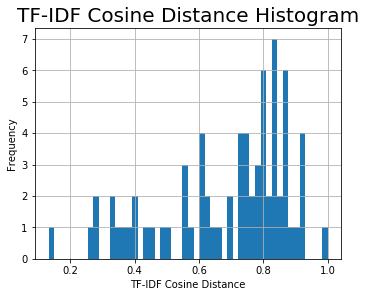

In [416]:
# with PdfPages(data_path + '/tfidf_cosine_hist.pdf') as pdf:
#     fig, ax = plt.subplots()
#     fig.set_size_inches(0.5 * 11, 0.5 * 8.5)
#     ax.hist(distances, bins = 50)
#     ax.grid()
#     ax.set_title("TF-IDF Cosine Distance Histogram", fontsize = 20)
#     ax.set_xlabel("TF-IDF Cosine Distance")
#     ax.set_ylabel("Frequency")
    
#     pdf.savefig(fig)
#     plt.show()

In [7]:
# with open(data_path + '/links.pickle', 'rb') as handle:
#     links_dict = pickle.load(handle)

# with open(data_path + '/titles.pickle', 'rb') as handle:
#     titles = pickle.load(handle)

In [8]:
# def wiki_labeled_pair_gen(titles, links_dict, n_titles = 100, maxlag = 5):
#     sess = requests.Session()
#     wapi_url = "https://en.wikipedia.org/w/api.php"
#     for origin_inds in grouper(links_dict, n_titles):
#         wapi_params = {
#             'action': "query",
#             'maxlag': maxlag,
#             'prop': "revisions",
#             'titles': '|'.join([titles[origin_ind - 1] for origin_ind in origin_inds if not origin_ind is None]),
#             'rvprop': "content",
#             'rvslots': "main",
#             'format': "json"
#         }
#         origin_data = sess.get(url = wapi_url, params = wapi_params).json()
# #         normalized_titles = {}
# #         for x in origin_data['query']['normalized']:
# #             normalized_titles[x['from']] = x['to']
#         origin_pages = iter(origin_data['query']['pages'].values())
#         for i in range(len(origin_inds)):
#             origin_ind = origin_inds[i]
#             if origin_ind is None:
#                 break
#             origin_sentences = [y for x in next(origin_pages)['revisions'][0]['slots']['main']['*'].split('\n') for y in nltk.sent_tokenize(x)]
#             for target_ind in links_dict[origin_ind]:
#                 for origin_sentence in origin_sentences:
#                     if (titles[target_ind - 1] + "]]" in origin_sentence) or (titles[target_ind - 1].replace('_', ' ') + "]]" in origin_sentence):
#                         yield (titles[origin_ind - 1], titles[target_ind - 1], origin_sentence, mwparserfromhell.parse(origin_sentence).strip_code())

In [144]:
# a = wiki_labeled_pair_gen(titles, links_dict, n_titles = 10, maxlag = 5)

In [220]:
# max_df = 0.9
# min_df = 1

# max_features = 1000

# min_n_gram = 1
# max_n_gram = 1

# count_vectorizer = CountVectorizer(min_df = min_df, max_df = max_df,
#                                    max_features = max_features,
#                                    ngram_range = (min_n_gram, max_n_gram),
#                                    stop_words = 'english').fit([' '.join(x) for x in sentence_tokens[0]])
# a = count_vectorizer.transform([' '.join(x) for x in sentence_tokens[0]]).toarray()
# b = count_vectorizer.transform([' '.join(x) for x in sentence_tokens[1]]).toarray()

In [223]:
# sdist.cdist(a, b)[0].argsort()

array([44,  3, 18, 13, 32, 20, 28,  1, 24, 37,  7, 33, 35, 43, 10,  6, 16,
       26, 38, 39,  5, 21,  8,  0, 25, 41, 34, 23, 19, 40, 36, 30, 29, 14,
       15, 27, 17, 22, 12,  9, 31,  4,  2, 42, 11])